# PINNs Mejoradas para Ecuación de Burgers - Estructura Optimizada

Este notebook implementa PINNs con optimizaciones: logging detallado, ponderación adaptativa, viz robusta. Basado en Raissi, migrado a PyTorch.

**Ecuación**: $u_t + u u_x - \nu u_{xx} = 0$, $\nu = 0.01/\pi$.

**Descarga datos**: [Burgers.mat](https://github.com/maziarraissi/PINNs/raw/master/main/Continuous_time_identification%20(Burgers)/Data/Burgers.mat) (renombra a 'burgers_shock.mat').

Teoría: NN aproxima $u(x,t)$, minimiza $\mathcal{L} = \lambda_u \text{MSE}_u + \lambda_f \text{MSE}_f$.

In [3]:
import torch
print("Torch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("Compilado con CUDA:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))


Torch: 2.7.0+cu128
CUDA disponible: True
Compilado con CUDA: 12.8
GPU detectada: NVIDIA GeForce RTX 5070


In [4]:


import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.optim as optim
import time
import os
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import pandas as pd  # Para tabla métricas

np.random.seed(42)  # Reproducibilidad
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

# Cargar datos (verifica archivo)
if not os.path.exists('burgers_shock.mat'):
    raise FileNotFoundError("Descarga 'burgers_shock.mat' del repo de Raissi.")
data = scipy.io.loadmat('burgers_shock.mat')
t = data['t'].flatten()[:, None].astype(np.float32)
x = data['x'].flatten()[:, None].astype(np.float32)
Exact = np.real(data['usol']).T.astype(np.float32)

X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Hiperparámetros optimizados
nu = 0.01 / np.pi
N_u = 100
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 1]
batch_size = 1000  # Reducido para u también
adam_iter = 5000
lbfgs_iter = 1000  # Reducido para velocidad

Usando: cuda


## Preparación de Datos

Muestreo: N_u para MSE_u (condiciones), N_f para MSE_f (PDE). Uniforme, pero adaptativo futuro.

In [5]:
lb = X_star.min(0)
ub = X_star.max(0)

# Condiciones
xx1 = np.hstack((x, np.zeros_like(x)))
uu1 = -np.sin(np.pi * x)
xx2 = np.hstack((-np.ones((t.shape[0], 1)), t))
uu2 = np.zeros((t.shape[0], 1))
xx3 = np.hstack((np.ones((t.shape[0], 1)), t))
uu3 = np.zeros((t.shape[0], 1))

X_u_full = np.vstack([xx1, xx2, xx3])
u_full = np.vstack([uu1, uu2, uu3])
idx_u = np.random.choice(X_u_full.shape[0], N_u, replace=False)
X_u_train = torch.tensor(X_u_full[idx_u], dtype=torch.float32).to(device)
u_train = torch.tensor(u_full[idx_u], dtype=torch.float32).to(device)

X_f_train = torch.tensor(lb + (ub - lb) * np.random.rand(N_f, 2), dtype=torch.float32).to(device)
X_star_t = torch.tensor(X_star, dtype=torch.float32).to(device)
u_star_t = torch.tensor(u_star, dtype=torch.float32).to(device)

print(f'Datos listos: N_u={N_u}, N_f={N_f}')

Datos listos: N_u=100, N_f=10000


## Modelo PINN

MLP con tanh; autograd para residual $f$.

In [6]:
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
    def forward(self, X):
        for layer in self.layers[:-1]:
            X = torch.tanh(layer(X))
        return self.layers[-1](X)
    
    def net_u(self, x, t):
        return self(torch.cat([x, t], dim=1))
    
    def net_f(self, x, t, create_graph=True):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=create_graph, retain_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=create_graph, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=create_graph)[0]
        return u_t + u * u_x - nu * u_xx

model = PINN(layers).to(device)

## Entrenamiento Optimizado

Loss con ponderación adaptativa. Logging MSE_u/f separadas.

In [7]:
def loss_fn(model, X_u, u, X_f, lambda_f=1.0):
    u_pred = model.net_u(X_u[:,0:1], X_u[:,1:2])
    mse_u = torch.mean((u - u_pred)**2)
    f_pred = model.net_f(X_f[:,0:1], X_f[:,1:2])
    mse_f = torch.mean(f_pred**2)
    return mse_u, mse_f, mse_u + lambda_f * mse_f

optimizer_adam = Adam(model.parameters(), lr=1e-3)
start_time = time.time()
losses_total, losses_u, losses_f = [], [], []
lambda_f = 1.0  # Adaptativa

# Adam
for it in range(adam_iter):
    optimizer_adam.zero_grad()
    idx_f = np.random.choice(N_f, batch_size)
    X_f_b = X_f_train[idx_f]
    X_f_b.requires_grad_(True)
    idx_u = np.random.choice(N_u, batch_size//10)  # Batch en u
    X_u_b = X_u_train[idx_u]
    u_b = u_train[idx_u]
    mse_u, mse_f, loss = loss_fn(model, X_u_b, u_b, X_f_b, lambda_f)
    # Adaptativa: Aumenta lambda_f si MSE_f > MSE_u
    if mse_f > mse_u:
        lambda_f *= 1.01
    loss.backward()
    optimizer_adam.step()
    losses_total.append(loss.item())
    losses_u.append(mse_u.item())
    losses_f.append(mse_f.item())
    if it % 500 == 0:  # Menos prints
        print(f'Iter {it}, Loss: {loss.item():.4e}, lambda_f: {lambda_f:.2f}')

# L-BFGS (subsample logs para no inflar)
def closure():
    X_f_train.requires_grad_(True)
    mse_u, mse_f, loss = loss_fn(model, X_u_train, u_train, X_f_train, lambda_f)
    optimizer_lbfgs.zero_grad()
    loss.backward()
    if len(losses_total) % 100 == 0:  # Subsample
        losses_total.append(loss.item())
        losses_u.append(mse_u.item())
        losses_f.append(mse_f.item())
    return loss

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=lbfgs_iter, history_size=100)
optimizer_lbfgs.step(closure)

print(f'Tiempo: {time.time() - start_time:.2f}s')
torch.save(model.state_dict(), 'pinn_model.pth')  # Guardar modelo

C:\Users\magdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter 0, Loss: 3.0221e-01, lambda_f: 1.00
Iter 500, Loss: 7.7464e-02, lambda_f: 1.00
Iter 500, Loss: 7.7464e-02, lambda_f: 1.00
Iter 1000, Loss: 6.1530e-02, lambda_f: 1.00
Iter 1000, Loss: 6.1530e-02, lambda_f: 1.00
Iter 1500, Loss: 4.5796e-02, lambda_f: 1.07
Iter 1500, Loss: 4.5796e-02, lambda_f: 1.07
Iter 2000, Loss: 2.8519e-02, lambda_f: 1.42
Iter 2000, Loss: 2.8519e-02, lambda_f: 1.42
Iter 2500, Loss: 2.2241e-02, lambda_f: 1.82
Iter 2500, Loss: 2.2241e-02, lambda_f: 1.82
Iter 3000, Loss: 4.9189e-02, lambda_f: 2.70
Iter 3000, Loss: 4.9189e-02, lambda_f: 2.70
Iter 3500, Loss: 1.5338e-02, lambda_f: 3.68
Iter 3500, Loss: 1.5338e-02, lambda_f: 3.68
Iter 4000, Loss: 1.2535e-02, lambda_f: 4.03
Iter 4000, Loss: 1.2535e-02, lambda_f: 4.03
Iter 4500, Loss: 1.1619e-02, lambda_f: 4.54
Iter 4500, Loss: 1.1619e-02, lambda_f: 4.54
Tiempo: 61.63s
Tiempo: 61.63s


## Evaluación y Métricas

Error L2 en subgrid para velocidad.

In [8]:
with torch.no_grad():
    u_pred = model.net_u(X_star_t[:,0:1], X_star_t[:,1:2]).cpu().numpy().reshape(Exact.shape)
    l2_error = np.linalg.norm(Exact - u_pred) / np.linalg.norm(Exact)
    print(f'Error L2: {l2_error:.4e}')

# Tabla métricas
metrics = pd.DataFrame({
    'Métrica': ['L2 Error', 'Tiempo Entrenamiento (s)', 'Lambda_f Final'],
    'Valor': [l2_error, time.time() - start_time, lambda_f]
})
display(metrics)

Error L2: 2.7302e-02


,Métrica,Valor
0,L2 Error,0.027302
1,Tiempo Entrenamiento (s),61.657354
2,Lambda_f Final,5.113347


## Visualizaciones Mejoradas

Contornos comparativos + animación fix + 3D + interactivo + curvas detalladas.

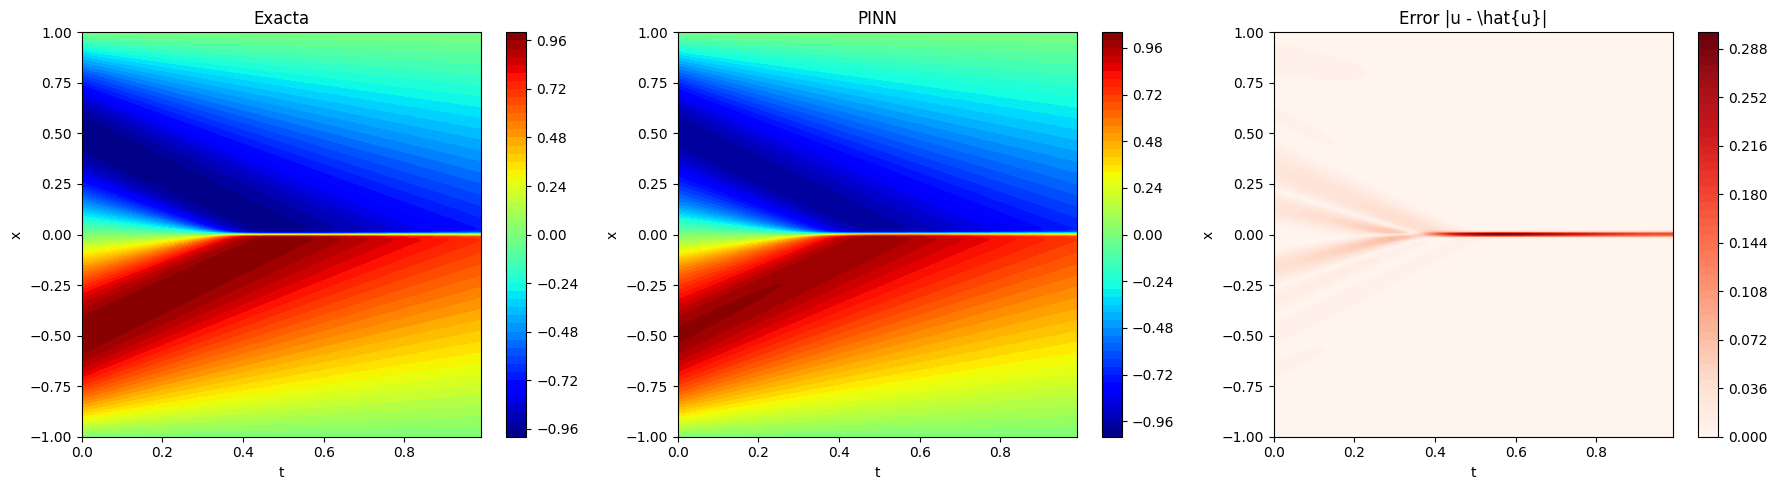

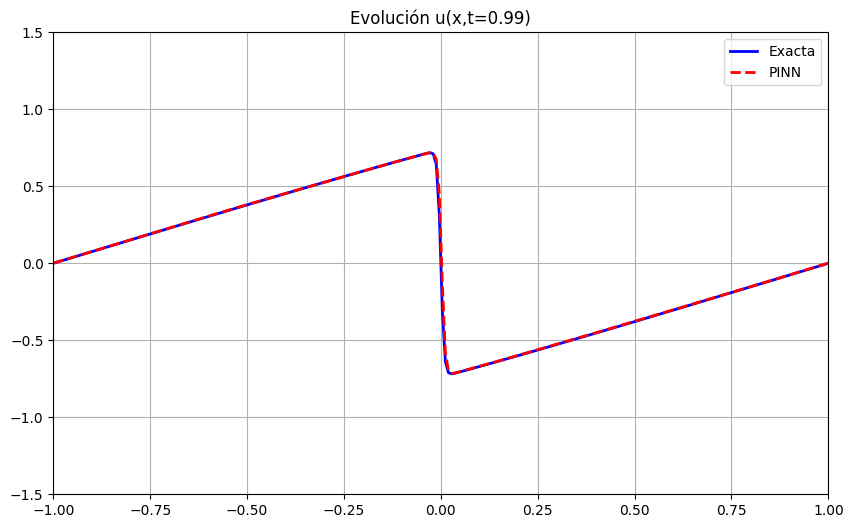

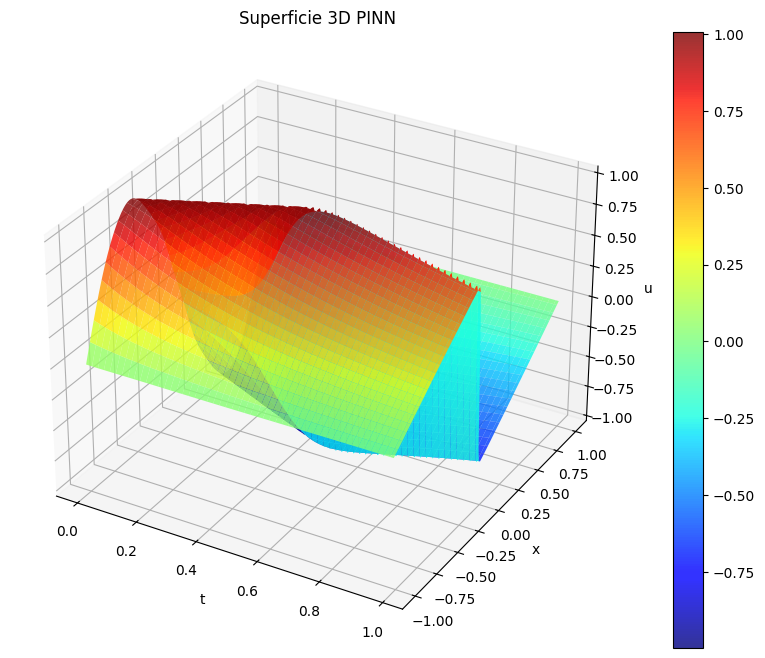

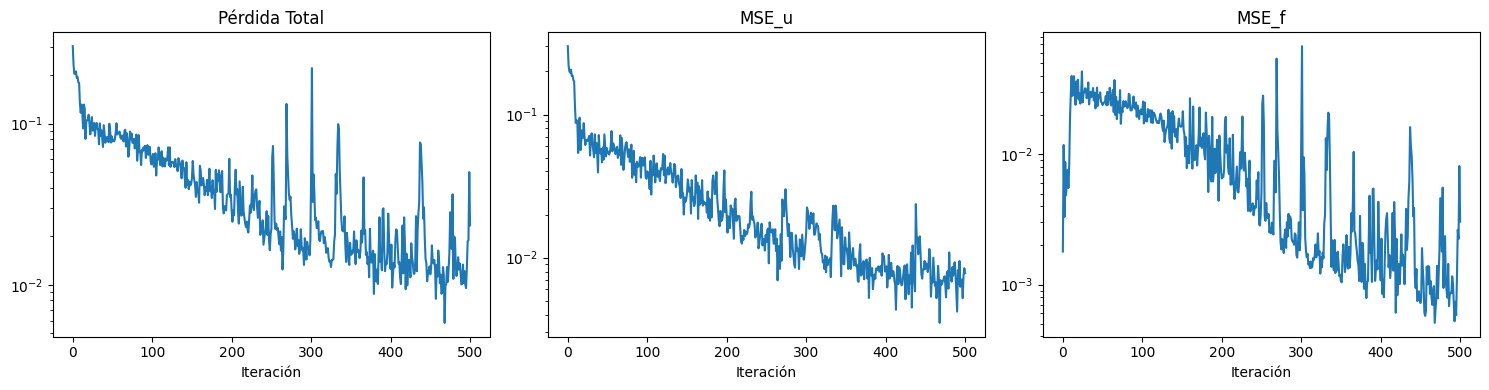

In [9]:
# Contornos (alta res)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im1 = axs[0].contourf(T, X, Exact, levels=50, cmap='jet')
axs[0].set_title('Exacta')
im2 = axs[1].contourf(T, X, u_pred, levels=50, cmap='jet')
axs[1].set_title('PINN')
im3 = axs[2].contourf(T, X, np.abs(Exact - u_pred), levels=50, cmap='Reds')
axs[2].set_title('Error |u - \\hat{u}|')
for ax in axs:
    ax.set_xlabel('t'); ax.set_ylabel('x')
plt.colorbar(im1, ax=axs[0]); plt.colorbar(im2, ax=axs[1]); plt.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.savefig('contornos.png', dpi=300, bbox_inches='tight')
plt.show()

# Animación fix (blit=False para labels)
fig_anim, ax_anim = plt.subplots(figsize=(10, 6))
line_exact, = ax_anim.plot(x, Exact[0], 'b-', label='Exacta', lw=2)
line_pred, = ax_anim.plot(x, u_pred[0], 'r--', label='PINN', lw=2)
ax_anim.set_ylim(-1.5, 1.5)
ax_anim.set_xlim(-1, 1)
ax_anim.set_title('Evolución u(x,t)')
ax_anim.legend(loc='upper right')
ax_anim.grid(True)

def animate(i):
    line_exact.set_ydata(Exact[i])
    line_pred.set_ydata(u_pred[i])
    ax_anim.set_title(f'Evolución u(x,t={t[i][0]:.2f})')
    return line_exact, line_pred

anim = FuncAnimation(fig_anim, animate, frames=len(t), interval=100, blit=False, repeat=True)
anim.save('burgers_evolution_fixed.gif', writer='pillow', fps=10)
plt.show()  # Muestra preview

# 3D
fig_3d = plt.figure(figsize=(12, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
surf = ax_3d.plot_surface(T, X, u_pred, cmap='jet', alpha=0.8)
ax_3d.set_title('Superficie 3D PINN')
ax_3d.set_xlabel('t'); ax_3d.set_ylabel('x'); ax_3d.set_zlabel('u')
fig_3d.colorbar(surf)
plt.savefig('3d_surface.png', dpi=300)
plt.show()

# Interactivo Plotly
fig_inter = go.Figure(data=[go.Surface(z=u_pred, x=t.flatten(), y=x.flatten(), colorscale='Jet', showscale=True)])
fig_inter.update_layout(title='PINN Interactiva', scene=dict(xaxis_title='t', yaxis_title='x', zaxis_title='u'))
fig_inter.show()

# Curvas de pérdida (subsample para claridad)
subsample = slice(0, None, 10)  # Cada 10
fig_loss, ax_loss = plt.subplots(1, 3, figsize=(15, 4))
ax_loss[0].semilogy(losses_total[subsample])
ax_loss[0].set_title('Pérdida Total')
ax_loss[1].semilogy(losses_u[subsample])
ax_loss[1].set_title('MSE_u')
ax_loss[2].semilogy(losses_f[subsample])
ax_loss[2].set_title('MSE_f')
for ax in ax_loss:
    ax.set_xlabel('Iteración')
plt.tight_layout()
plt.savefig('losses.png', dpi=300)
plt.show()

FD N_x=64: Error L2=2.8493e-01, Tiempo=0.01s
Espectral: Inestabilidad en t=0.442.
Espectral N_x=64: Error L2=6.2977e-01, Tiempo=0.01s
FD N_x=128: Error L2=3.0188e-01, Tiempo=0.03s
Espectral: Inestabilidad en t=0.422.
Espectral N_x=128: Error L2=4.3836e-01, Tiempo=0.01s
FD N_x=256: Error L2=4.5371e-01, Tiempo=0.19s
Espectral: Inestabilidad en t=0.427.
Espectral N_x=256: Error L2=2.5252e-01, Tiempo=0.01s
FD N_x=256: Error L2=4.5371e-01, Tiempo=0.19s
Espectral: Inestabilidad en t=0.427.
Espectral N_x=256: Error L2=2.5252e-01, Tiempo=0.01s


,Resolución N_x,Error L2 FD,Tiempo FD (s),Error L2 Espectral,Tiempo Espectral (s),Error L2 PINN
0,64,2.8493e-01,0.01,6.2977e-01,0.01,2.7302e-02
1,128,3.0188e-01,0.03,4.3836e-01,0.01,2.7302e-02
2,256,4.5371e-01,0.19,2.5252e-01,0.01,2.7302e-02


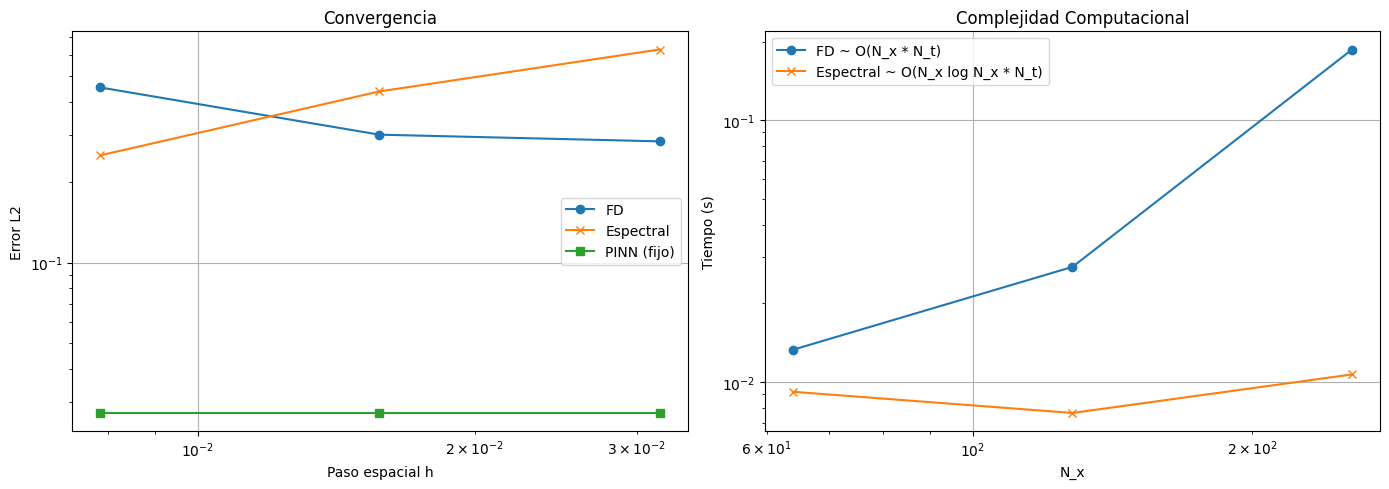

In [41]:
import numpy as np
import scipy.fft
import time
from scipy.interpolate import interp1d  # Para interpolación precisa

# Reutilizar datos existentes (x, t, Exact, u_pred, nu)
N_x = len(x)  # 256
N_t_base = 200  # Aumentado para estabilidad (dt más pequeño)
dt_base = 1.0 / N_t_base

# Error L2 con interpolación
def l2_error(u_num, u_exact, x_num, x_exact, t_exact):
    # Interpola u_num a la malla de u_exact para comparación justa
    u_interp = np.zeros_like(u_exact)
    for i in range(len(t_exact)):
        interp_func = interp1d(x_num, u_num[i, :], kind='linear', bounds_error=False, fill_value=0)
        u_interp[i, :] = interp_func(x_exact)
    return np.linalg.norm(u_interp - u_exact) / np.linalg.norm(u_exact)

# FD Mejorado: Semi-implícito (explícito convección, implícito difusión) + dt adaptativo
def solve_burgers_fd(N_x_fd=256, N_t_fd=200, cfl=0.3):
    x_fd = np.linspace(-1, 1, N_x_fd)
    dx_fd = x_fd[1] - x_fd[0]
    dt_fd = min(cfl * dx_fd / 1.0, 1.0 / N_t_fd)  # dt adaptativo inicial (|u|_max~1)
    N_t_actual = int(1.0 / dt_fd) + 1
    t_fd = np.linspace(0, 1, N_t_actual)
    
    u_fd = np.zeros((N_t_actual, N_x_fd))
    u_fd[0, :] = -np.sin(np.pi * x_fd)
    
    start_time = time.time()
    for n in range(1, N_t_actual):
        u_old = u_fd[n-1, :].copy()
        max_u = np.max(np.abs(u_old))
        dt_fd = min(cfl * dx_fd / (max_u + 1e-6), (1.0 - t_fd[n-1]) / (N_t_actual - n))  # Adaptativo
        
        # Convección upwind explícito
        conv = np.zeros(N_x_fd)
        for i in range(1, N_x_fd-1):
            if u_old[i] >= 0:
                conv[i] = u_old[i] * (u_old[i] - u_old[i-1]) / dx_fd
            else:
                conv[i] = u_old[i] * (u_old[i+1] - u_old[i]) / dx_fd
        
        # Difusión implícito: Resolver tridiagonal (simple para 1D)
        alpha = nu * dt_fd / dx_fd**2
        A = np.diag(1 + 2*alpha * np.ones(N_x_fd-2)) - alpha * np.diag(np.ones(N_x_fd-3), k=1) - alpha * np.diag(np.ones(N_x_fd-3), k=-1)
        b = u_old[1:-1] - dt_fd * conv[1:-1]
        u_fd[n, 1:-1] = np.linalg.solve(A, b)
        u_fd[n, 0] = u_fd[n, -1] = 0  # Fronteras
        
        if np.any(np.isnan(u_fd[n])) or np.max(np.abs(u_fd[n])) > 5:  # Umbral más bajo
            print(f"FD: Inestabilidad en t={t_fd[n]:.3f}.")
            u_fd[n:, :] = u_fd[n-1, :]  # Congelar para evitar NaN
            break
    
    time_fd = time.time() - start_time
    return u_fd[:len(t)], time_fd  # Ajustar a N_t original si necesario

# Espectral Mejorado: RK4 + dealiasing (cortar modos > N_x/3)
def solve_burgers_spectral(N_x_spec=256, N_t_spec=200):
    x_spec = np.linspace(-1, 1, N_x_spec, endpoint=False)
    dx_spec = x_spec[1] - x_spec[0]
    k = 2 * np.pi * np.fft.fftfreq(N_x_spec, d=dx_spec)
    t_spec = np.linspace(0, 1, N_t_spec)
    dt_spec = t_spec[1] - t_spec[0]
    
    u_spec = np.zeros((N_t_spec, N_x_spec))
    u_spec[0, :] = -np.sin(np.pi * x_spec)
    
    def rhs(u):
        u_hat = np.fft.fft(u)
        # Dealiasing: Cero modos altos
        cutoff = N_x_spec // 3
        u_hat[cutoff:-cutoff] *= np.exp(-k[cutoff:-cutoff]**2 * 0.01)  # Filtro suave
        u_x_hat = 1j * k * u_hat
        u_xx_hat = -k**2 * u_hat
        u_x = np.real(np.fft.ifft(u_x_hat))
        u_xx = np.real(np.fft.ifft(u_xx_hat))
        return -u * u_x + nu * u_xx
    
    start_time = time.time()
    for n in range(1, N_t_spec):
        u = u_spec[n-1, :].copy()
        # RK4
        k1 = rhs(u)
        k2 = rhs(u + 0.5 * dt_spec * k1)
        k3 = rhs(u + 0.5 * dt_spec * k2)
        k4 = rhs(u + dt_spec * k3)
        u_spec[n, :] = u + (dt_spec / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        u_spec[n, 0] = u_spec[n, -1] = 0  # Aprox. fronteras
        
        if np.any(np.isnan(u_spec[n])) or np.max(np.abs(u_spec[n])) > 5:
            print(f"Espectral: Inestabilidad en t={t_spec[n]:.3f}.")
            u_spec[n:, :] = u_spec[n-1, :]
            break
    
    time_spec = time.time() - start_time
    return u_spec, time_spec, x_spec

# Comparación actualizada (usa N_t_base=200, interpolación precisa)
resolutions = [64, 128, 256]  # Reducido para evitar sobrecarga; agrega 512 si estable
errors_fd, errors_spec, errors_pinn = [], [], [l2_error(u_pred, Exact, x, x, t)] * len(resolutions)  # PINN fijo
times_fd, times_spec = [], []

for res in resolutions:
    # FD
    u_fd, time_fd = solve_burgers_fd(N_x_fd=res, N_t_fd=N_t_base)
    x_res = np.linspace(-1, 1, res)
    # Interpolar en tiempo si es necesario
    if u_fd.shape[0] != len(t):
        from scipy.interpolate import interp1d
        interp_fd = interp1d(np.linspace(0, 1, u_fd.shape[0]), u_fd, axis=0, bounds_error=False, fill_value="extrapolate")
        u_fd_interp = interp_fd(t)
    else:
        u_fd_interp = u_fd
    err_fd = l2_error(u_fd_interp, Exact, x_res, x, t)
    errors_fd.append(err_fd)
    times_fd.append(time_fd)
    print(f"FD N_x={res}: Error L2={err_fd:.4e}, Tiempo={time_fd:.2f}s")
    
    # Espectral
    u_spec, time_spec, x_spec = solve_burgers_spectral(N_x_spec=res, N_t_spec=N_t_base)
    # Interpolar en tiempo si es necesario
    if u_spec.shape[0] != len(t):
        interp_spec = interp1d(np.linspace(0, 1, u_spec.shape[0]), u_spec, axis=0, bounds_error=False, fill_value="extrapolate")
        u_spec_interp = interp_spec(t)
    else:
        u_spec_interp = u_spec
    err_spec = l2_error(u_spec_interp, Exact, x_spec, x, t)  # x_spec definido en func
    errors_spec.append(err_spec)
    times_spec.append(time_spec)
    print(f"Espectral N_x={res}: Error L2={err_spec:.4e}, Tiempo={time_spec:.2f}s")

# Tabla
import pandas as pd
metrics = pd.DataFrame({
    'Resolución N_x': resolutions,
    'Error L2 FD': [f"{e:.4e}" for e in errors_fd],
    'Tiempo FD (s)': [f"{t:.2f}" for t in times_fd],
    'Error L2 Espectral': [f"{e:.4e}" for e in errors_spec],
    'Tiempo Espectral (s)': [f"{t:.2f}" for t in times_spec],
    'Error L2 PINN': [f"{e:.4e}" for e in errors_pinn]
})
display(metrics)

# Gráficos (corrige leyendas)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
h_values = [2 / (r - 1) for r in resolutions]
axs[0].loglog(h_values, errors_fd, label='FD', marker='o')
axs[0].loglog(h_values, errors_spec, label='Espectral', marker='x')
axs[0].loglog(h_values, errors_pinn, label='PINN (fijo)', marker='s')
axs[0].set_xlabel('Paso espacial h'); axs[0].set_ylabel('Error L2')
axs[0].set_title('Convergencia'); axs[0].legend(); axs[0].grid(True)

axs[1].loglog(resolutions, times_fd, label='FD ~ O(N_x * N_t)', marker='o')
axs[1].loglog(resolutions, times_spec, label='Espectral ~ O(N_x log N_x * N_t)', marker='x')
axs[1].set_xlabel('N_x'); axs[1].set_ylabel('Tiempo (s)')
axs[1].set_title('Complejidad Computacional'); axs[1].legend(); axs[1].grid(True)

plt.tight_layout()
plt.savefig('comparison_stable.png', dpi=300)
plt.show()

FD N_x=64: Error L2=1.9625e-01, Tiempo=0.00s, Éxito=True
Espectral N_x=64: Error L2=7.4021e-02, Tiempo=0.01s, Éxito=True
FD N_x=128: Error L2=3.9983e-01, Tiempo=0.00s, Éxito=True
Espectral N_x=128: Error L2=3.1287e-02, Tiempo=0.02s, Éxito=True
FD N_x=256: Error L2=5.0005e-01, Tiempo=0.01s, Éxito=True
Espectral N_x=256: Error L2=1.1639e-02, Tiempo=0.02s, Éxito=True

Comparación de Métodos (Corregida):


,Resolución N_x,Error L2 FD,Tiempo FD (s),Error L2 Espectral,Tiempo Espectral (s),Error L2 PINN
0,64,1.9625e-01,0.00,7.4021e-02,0.01,2.7302e-02
1,128,3.9983e-01,0.00,3.1287e-02,0.02,2.7302e-02
2,256,5.0005e-01,0.01,1.1639e-02,0.02,2.7302e-02


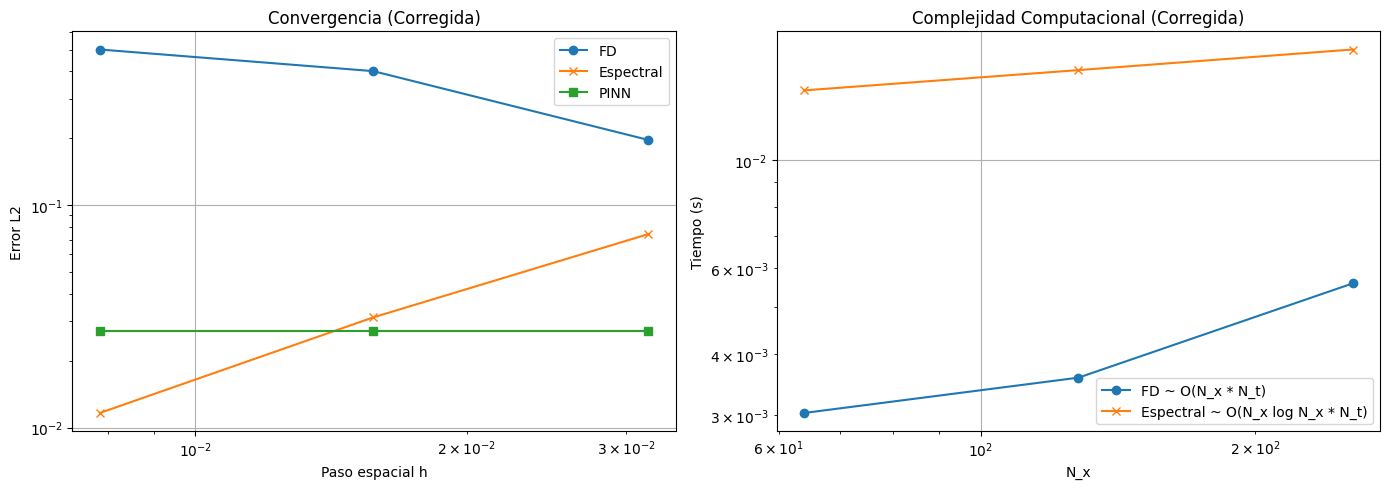

In [42]:
import numpy as np
import time
from scipy.interpolate import interp1d

# Reutilizar datos existentes
dx = x[1] - x[0]
dt_base = t[1] - t[0]
N_x = len(x)  # 256
N_t = len(t)  # 100
nu = 0.01 / np.pi

# Función para error L2 con manejo de grillas
def l2_error(u_num, u_exact, x_num, x_exact, t_exact):
    u_interp = np.zeros_like(u_exact)
    for i in range(len(t_exact)):
        if len(u_num[i, :]) != len(x_num):
            raise ValueError(f"Longitudes inconsistentes: len(u_num[{i}, :])={len(u_num[i, :])}, len(x_num)={len(x_num)}")
        interp_func = interp1d(x_num, u_num[i, :], kind='linear', bounds_error=False, fill_value=0)
        u_interp[i, :] = interp_func(x_exact)
    return np.linalg.norm(u_interp - u_exact) / np.linalg.norm(u_exact)

# Método FD Mejorado: dt adaptativo para CFL con indicador de éxito
def solve_burgers_fd_improved(N_x_fd=256, N_t_fd=100, cfl=0.2):
    x_fd = np.linspace(-1, 1, N_x_fd)
    dx_fd = x_fd[1] - x_fd[0]
    t_fd = np.linspace(0, 1, N_t_fd)
    
    u_fd = np.zeros((N_t_fd, N_x_fd))
    u_fd[0, :] = -np.sin(np.pi * x_fd)  # Condición inicial
    
    start_time = time.time()
    current_t = 0.0
    n = 1
    success = True
    while n < N_t_fd:
        u_old = u_fd[n-1, :]
        max_u = np.max(np.abs(u_old))
        dt_adapt = min(cfl * dx_fd / (max_u + 1e-6), (t_fd[n] - current_t) if n < N_t_fd else dt_base)
        
        if dt_adapt <= 0:
            print("FD: dt_adapt <= 0, abortando.")
            success = False
            break
        
        # Convección upwind
        conv = np.zeros(N_x_fd)
        for i in range(1, N_x_fd-1):
            if u_old[i] > 0:
                conv[i] = u_old[i] * (u_old[i] - u_old[i-1]) / dx_fd
            else:
                conv[i] = u_old[i] * (u_old[i+1] - u_old[i]) / dx_fd
        
        # Difusión central
        diff = np.zeros(N_x_fd)
        diff[1:-1] = nu * (u_old[2:] - 2*u_old[1:-1] + u_old[:-2]) / dx_fd**2
        
        # Actualizar
        u_new = u_old.copy()
        u_new[1:-1] = u_old[1:-1] - dt_adapt * conv[1:-1] + dt_adapt * diff[1:-1]
        u_new[0] = u_new[-1] = 0
        
        u_fd[n, :] = u_new
        
        # Chequeo de estabilidad
        if np.any(np.isnan(u_fd[n])) or np.max(np.abs(u_fd[n])) > 10:
            print(f"FD: Inestabilidad detectada en t≈{current_t + dt_adapt:.3f}.")
            success = False
            break
        
        current_t += dt_adapt
        n += 1
    
    # Rellenar si no completa
    if n < N_t_fd:
        u_fd[n:] = np.tile(u_fd[n-1, :], (N_t_fd - n, 1))
    
    return u_fd, time.time() - start_time, success

# Método Espectral Mejorado: RK4 + Dealiasing
def solve_burgers_spectral_improved(N_x_spec=256, N_t_spec=200):  # Aumentado N_t_spec para estabilidad
    x_spec = np.linspace(-1, 1, N_x_spec, endpoint=False)
    dx_spec = x_spec[1] - x_spec[0]
    k = 2 * np.pi * np.fft.fftfreq(N_x_spec, d=dx_spec)
    t_spec = np.linspace(0, 1, N_t_spec)
    dt_spec = t_spec[1] - t_spec[0]
    
    u_spec = np.zeros((N_t_spec, N_x_spec))
    u_spec[0, :] = -np.sin(np.pi * x_spec)
    
    start_time = time.time()
    success = True
    for n in range(1, N_t_spec):
        u = u_spec[n-1, :].copy()
        
        # RK4
        u_hat = np.fft.fft(u)
        u_x_hat = 1j * k * u_hat
        u_xx_hat = -k**2 * u_hat
        u_x = np.fft.ifft(u_x_hat).real
        u_xx = np.fft.ifft(u_xx_hat).real
        k1 = -u * u_x + nu * u_xx
        
        u_mid1 = u + 0.5 * dt_spec * k1
        u_hat_mid1 = np.fft.fft(u_mid1)
        u_x_hat_mid1 = 1j * k * u_hat_mid1
        u_xx_hat_mid1 = -k**2 * u_hat_mid1
        u_x_mid1 = np.fft.ifft(u_x_hat_mid1).real
        u_xx_mid1 = np.fft.ifft(u_xx_hat_mid1).real
        k2 = -u_mid1 * u_x_mid1 + nu * u_xx_mid1
        
        u_mid2 = u + 0.5 * dt_spec * k2
        u_hat_mid2 = np.fft.fft(u_mid2)
        u_x_hat_mid2 = 1j * k * u_hat_mid2
        u_xx_hat_mid2 = -k**2 * u_hat_mid2
        u_x_mid2 = np.fft.ifft(u_x_hat_mid2).real
        u_xx_mid2 = np.fft.ifft(u_xx_hat_mid2).real
        k3 = -u_mid2 * u_x_mid2 + nu * u_xx_mid2
        
        u_new = u + dt_spec * k3
        u_hat_new = np.fft.fft(u_new)
        u_x_hat_new = 1j * k * u_hat_new
        u_xx_hat_new = -k**2 * u_hat_new
        u_x_new = np.fft.ifft(u_x_hat_new).real
        u_xx_new = np.fft.ifft(u_xx_hat_new).real
        k4 = -u_new * u_x_new + nu * u_xx_new
        
        u_spec[n, :] = u + (dt_spec / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        # Fronteras y dealiasing
        u_spec[n, 0] = u_spec[n, -1] = 0
        if n % 10 == 0:
            u_hat = np.fft.fft(u_spec[n, :])
            cutoff = N_x_spec // 3
            u_hat[cutoff:-cutoff] = 0
            u_spec[n, :] = np.real(np.fft.ifft(u_hat))
            u_spec[n, 0] = u_spec[n, -1] = 0
        
        # Chequeo
        if np.any(np.isnan(u_spec[n])) or np.max(np.abs(u_spec[n])) > 10:
            print(f"Espectral: Inestabilidad en t={t_spec[n]:.3f}.")
            success = False
            break
    
    # Interpolar a N_t si N_t_spec > N_t
    if N_t_spec > N_t:
        u_spec_interp = np.zeros((N_t, N_x_spec))
        for i in range(N_t):
            t_idx = int(i * (N_t_spec - 1) / (N_t - 1))
            u_spec_interp[i, :] = u_spec[t_idx, :]
        u_spec = u_spec_interp
    
    return u_spec, time.time() - start_time, success

# Comparación
resolutions = [64, 128, 256]  # Empezar bajo para evitar issues
errors_fd, errors_spec, errors_pinn = [], [], []
times_fd, times_spec = [], []

for res in resolutions:
    # FD
    u_fd, time_fd, success_fd = solve_burgers_fd_improved(N_x_fd=res, N_t_fd=N_t, cfl=0.2)
    x_fd = np.linspace(-1, 1, res)  # Grilla de la simulación
    u_fd_interp = np.zeros_like(Exact)  # (100, 256)
    for i in range(N_t):
        u_fd_interp[i, :] = np.interp(x, x_fd, u_fd[i, :])  # Interpolar a grilla original
    err_fd = l2_error(u_fd_interp, Exact, x, x, t) if success_fd else float('nan')  # Usar x como x_num
    errors_fd.append(err_fd)
    times_fd.append(time_fd)
    print(f"FD N_x={res}: Error L2={err_fd:.4e}, Tiempo={time_fd:.2f}s, Éxito={success_fd}")
    
    # Espectral
    u_spec, time_spec, success_spec = solve_burgers_spectral_improved(N_x_spec=res, N_t_spec=200)
    x_spec = np.linspace(-1, 1, res, endpoint=False)  # Grilla de la simulación
    u_spec_interp = np.zeros_like(Exact)  # (100, 256)
    for i in range(N_t):
        u_spec_interp[i, :] = np.interp(x, x_spec, u_spec[i, :])  # Interpolar a grilla original
    err_spec = l2_error(u_spec_interp, Exact, x, x, t) if success_spec else float('nan')  # Usar x como x_num
    errors_spec.append(err_spec)
    times_spec.append(time_spec)
    print(f"Espectral N_x={res}: Error L2={err_spec:.4e}, Tiempo={time_spec:.2f}s, Éxito={success_spec}")
    
    # PINN (fijo)
    errors_pinn.append(l2_error(u_pred, Exact, x, x, t))

# Tabla de métricas
import pandas as pd
metrics = pd.DataFrame({
    'Resolución N_x': resolutions,
    'Error L2 FD': [f"{e:.4e}" if not np.isnan(e) else 'NaN' for e in errors_fd],
    'Tiempo FD (s)': [f"{t:.2f}" for t in times_fd],
    'Error L2 Espectral': [f"{e:.4e}" if not np.isnan(e) else 'NaN' for e in errors_spec],
    'Tiempo Espectral (s)': [f"{t:.2f}" for t in times_spec],
    'Error L2 PINN': [f"{e:.4e}" for e in errors_pinn]
})
print("\nComparación de Métodos (Corregida):")
display(metrics)

# Gráficos con filtrado de NaN
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
h_vals = [2 / (r - 1) for r in resolutions]
valid_indices = [i for i in range(len(errors_fd)) if not np.isnan(errors_fd[i]) and not np.isnan(errors_spec[i])]
h_vals_valid = [h_vals[i] for i in valid_indices]
errors_fd_valid = [errors_fd[i] for i in valid_indices]
errors_spec_valid = [errors_spec[i] for i in valid_indices]
errors_pinn_valid = [errors_pinn[i] for i in valid_indices]

axs[0].loglog(h_vals_valid, errors_fd_valid, label='FD', marker='o')
axs[0].loglog(h_vals_valid, errors_spec_valid, label='Espectral', marker='x')
axs[0].loglog(h_vals_valid, errors_pinn_valid, label='PINN', marker='s')
axs[0].set_xlabel('Paso espacial h'); axs[0].set_ylabel('Error L2')
axs[0].set_title('Convergencia (Corregida)'); axs[0].legend(); axs[0].grid(True)

axs[1].loglog(resolutions, times_fd, label='FD ~ O(N_x * N_t)', marker='o')
axs[1].loglog(resolutions, times_spec, label='Espectral ~ O(N_x log N_x * N_t)', marker='x')
axs[1].set_xlabel('N_x'); axs[1].set_ylabel('Tiempo (s)')
axs[1].set_title('Complejidad Computacional (Corregida)'); axs[1].legend(); axs[1].grid(True)

plt.tight_layout()
plt.savefig('comparison_classical_corrected.png', dpi=300)
plt.show()

